Found 4000 files belonging to 8 classes.
Using 3200 files for training.
Found 4000 files belonging to 8 classes.
Using 800 files for validation.
Epoch 1/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 962s 35s/step - accuracy: 0.5937 - loss: 2.5034 - val_accuracy: 0.6178 - val_loss: 6.6775 - learning_rate: 0.0010
Epoch 2/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 792s 31s/step - accuracy: 0.9518 - loss: 0.1284 - val_accuracy: 0.6178 - val_loss: 7.2549 - learning_rate: 0.0010
Epoch 3/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 797s 31s/step - accuracy: 0.9916 - loss: 0.0249 - val_accuracy: 0.7163 - val_loss: 6.0729 - learning_rate: 0.0010
Epoch 4/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 782s 30s/step - accuracy: 0.9964 - loss: 0.0120 - val_accuracy: 0.7236 - val_loss: 4.7627 - learning_rate: 0.0010
Epoch 5/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 808s 30s/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.6875 - val_loss: 5.1956 - learning_rate: 0.0010
Epoch 6/7
25/25 ━━━━━━━━━━━━━━━━━━━━ 766s 30s/step - accuracy: 1.0000 - loss: 9.4262e-04 - val_accur

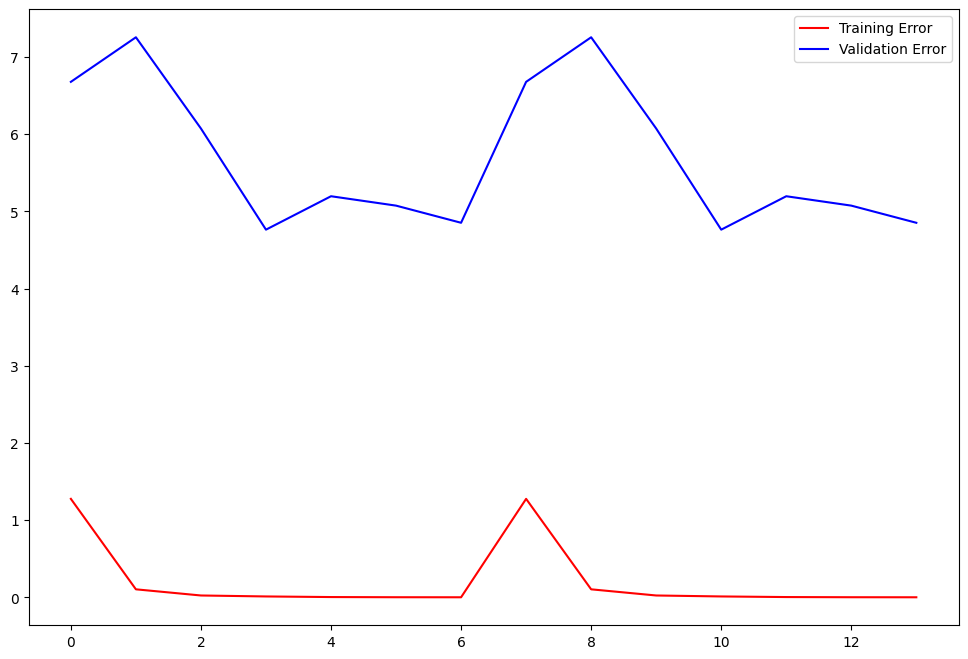

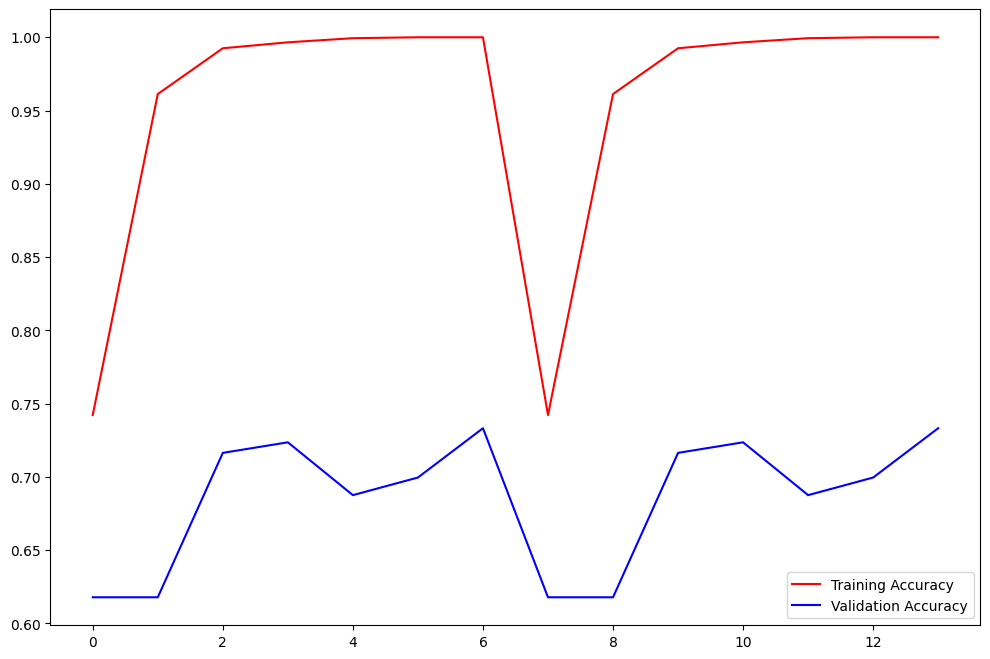

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 992ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Accuracy: 0.73
Confusion Matrix:
[[44  0  0  0  0  0  3  0]
 [47  1  0  0  0  3  0  0]
 [ 0  0 33  0  2  4  4  0]
 [ 0  0  0 34  0  0  9  0]
 [ 0  0  0  0 48  0  1  0]
 [ 0  0  3  0  1 33  4  0]
 [ 0  0  0  0  2  0 49  0]
 [ 0  0  0  0  3  0 19 37]]


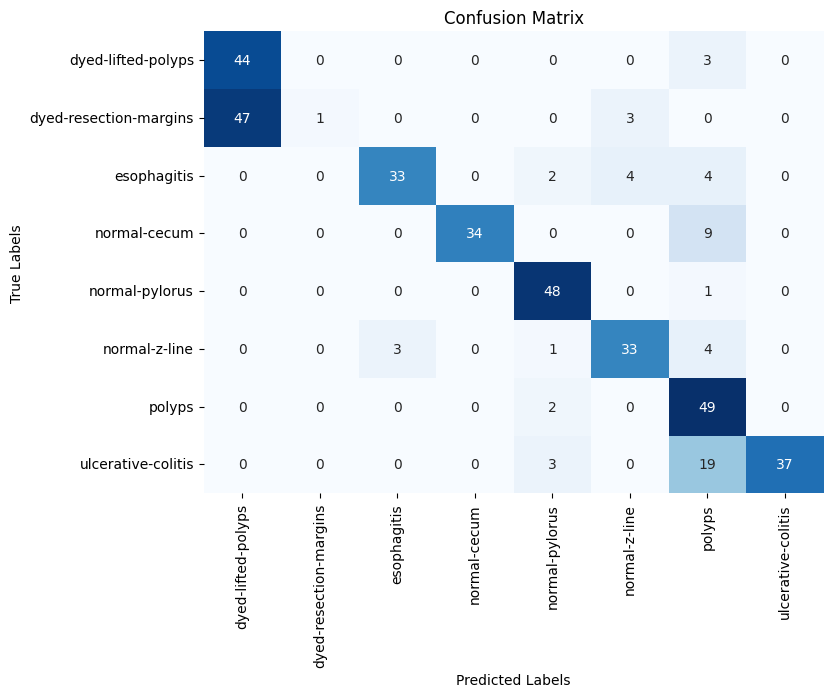

In [ ]:
import os
import shutil

import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

dataset_path = "/content/drive/MyDrive/kvasir-dataset"
image_size = 224, 224
batch_size = 128

train_ds = image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  label_mode="categorical",
  seed=23,
  image_size=image_size,
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  label_mode="categorical",
  seed=23,
  image_size=image_size,
  batch_size=batch_size)

class_names = train_ds.class_names
# Splitting Validation Dataset for Validation and Test
# Returns the cardinality of the data
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

# Prefetching Datasets for Improved Performance
# In machine learning workflows, data pipeline efficiency significantly impacts training speed. The prefetch method in TensorFlow helps optimize this pipeline by preparing data ahead of its actual usage during model training.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Constructing and Compiling a Transfer Learning Model
model = Sequential()
base_model = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape = (224,224, 3))


for layer in base_model.layers:
        layer.trainable=True
model.add(base_model)
model.add(Flatten())
model.add(Dense(8, activation='softmax'))
model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
          loss=CategoricalCrossentropy(),
          metrics=['accuracy'])

# print(model.summary())

# Callbacks for Model Training
# ReduceLROnPlateau is a callback that adjusts the learning rate when a monitored metric (in this case, 'val_loss') has stopped improving. It reduces the learning rate (factor=0.2) by a factor of 0.2 if there is no improvement in validation loss for patience=5 epochs. min_lr=1e-5 sets the minimum learning rate to 1e-5 to prevent further reduction.

# ModelCheckpoint is a callback used to save the model's weights during training.

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-5)

best = ModelCheckpoint(filepath="training_weights/best/model_best_val_accuracy.ckpt.weights.h5",
                                         save_weights_only=True,
                                         monitor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Training the model
model.fit(train_ds, epochs=7, validation_data=val_ds, callbacks=[reduce_lr, best, early_stop])

# Saving the model
model.save("finalMobileNetv3.h5")
# Plotting Training and Validation Metrics¶
# This helps in identifying when the models starts to overfit to the training data

history = model.history
loss = history.history['loss'] + history.history['loss']
val_loss = history.history['val_loss'] + history.history['val_loss']
accuracy = history.history['accuracy'] + history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + history.history['val_accuracy']
plt.figure(figsize=(12,8))
plt.plot(loss,color='r',label='Training Error')
plt.plot(val_loss, color='b',label='Validation Error')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(accuracy,color='r',label='Training Accuracy')
plt.plot(val_accuracy, color='b',label='Validation Accuracy')
plt.legend()
plt.show()

# Plotting the Confusion Matrix
true_labels = []
predicted_labels = []

# Iterate through test dataset to get true labels
for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Assuming one-hot encoded labels

    # Predict labels using the model
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Convert lists to NumPy arrays for easier processing
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/usr/local/lib/python3.10/dist-packages/keras/api/preprocessing/image/__init__.py)